In [39]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from functools import partial
import math
from sklearn.model_selection import train_test_split
from threshold_layer import ThresholdLayer
from utils import *

# Model

In [40]:
class LinearGreaterThanZero(nn.Linear):
    """Linear layer with weights constrained to be greater than zero.
    """
    def __init__(self,in_features:int, bias:bool=False, min_w:float=0.0000001):
        """Constructor for LinearGreaterThanZero

        Args:
            in_features (int): Number of input features/ criteria
            bias (bool, optional): Whether to include bias. Defaults to False.
            min_w (float, optional): Minimum value for the weights. Defaults to 0.0000001.
        """
        super().__init__(in_features,1, bias)
        self.is_bias = bias
        self.min_w = min_w
        if bias:
            nn.init.uniform_(self.bias, self.min_w ,1.)
        else:
            self.bias = None

    def reset_parameters(self):
        """Reset the weights of the layer"""
        nn.init.uniform_(self.weight, 0.1,1.)


    def w(self)->torch.Tensor:
        """Get the weights of the layer and apply the constraint that the weights 
            should be greater than zero.

        Returns:
            torch.Tensor: Weights of the layer
        """
        with torch.no_grad():
            self.weight.data[self.weight.data<0]=self.min_w
        return self.weight

    def forward(self, input:torch.Tensor)->torch.Tensor:
        """Forward pass of the layer

        Args:
            input (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        return F.linear(input, self.w(), self.bias)


In [41]:
class LinearInteraction(nn.Linear):
    """Linear layer for criteria interaction. It contains constraints that the inpact of each criteria should be positive.
    """
    def __init__(self,in_features:int, criterion_layer:LinearGreaterThanZero):
        """Constructor for LinearInteraction

        Args:
            in_features (int): Number of input features/ criteria.
            criterion_layer (LinearGreaterThanZero): Layer with the criteria weights.
        """
        super().__init__(((in_features-1)*in_features)//2,1, False)
        self.in_features = in_features
        self.criterion_layer = criterion_layer
        
    def reset_parameters(self):
        """Reset the weights of the layer.
        """
        nn.init.normal_(self.weight, 0.0,0.1)     
    
    def w(self)->torch.Tensor:
        """Get the weights of the layer and apply the constraint that the weights.

        Returns:
            torch.Tensor: Weights of the layer.
        """
        with torch.no_grad():
            w_i=0
            w = self.criterion_layer.w()
            for i in range(self.in_features):
                for j in range(i+1,self.in_features):
                    self.weight.data[:,w_i] =  torch.max(self.weight.data[:,w_i], -w[:,i])
                    self.weight.data[:,w_i] =  torch.max(self.weight.data[:,w_i], -w[:,j])
                    w_i+=1
        return self.weight
        
    def forward(self, input:torch.Tensor)->torch.Tensor:
        """Forward pass of the layer.

        Args:
            input (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        return F.linear(input, self.w(), None)

In [42]:

class ChoquetIntegralConstrained(nn.Module):
    """Choquet Integral model with constraints on the weights.
    """
    def __init__(self, num_criteria:int):
        """Constructor for ChoquetIntegralConstrained

        Args:
            num_criteria (int): Number of criteria.
        """
        super().__init__()
        self.num_criteria = num_criteria
        self.criteria_layer = LinearGreaterThanZero(num_criteria)
        self.interaction_layer = LinearInteraction(num_criteria,self.criteria_layer)
        self.threshold_layer = ThresholdLayer()
    
    def forward(self, input:torch.Tensor)->torch.Tensor:
        """Forward pass of the model.

        Args:
            input (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """        """"""    
        if len(input.shape)==3:
            input = input[:,0,:]
        
        # Calculate the criteria part of integral
        x_wi = self.criteria_layer(input[:,:self.num_criteria])     
        # Calculate the interaction part of integral 
        x_wij = self.interaction_layer(input[:,self.num_criteria:])
        # Normalize scores
        weight_sum = self.criteria_layer.w().sum()+self.interaction_layer.w().sum()
        score =  (x_wi+x_wij)/(weight_sum)
        return self.threshold_layer(score)

In [43]:
def mobious_transform(row:list|np.ndarray)->list:
    """Mobious transform of the input row.
    First n values are the criteria values and the rest are the minimum values of the pairs of criteria.

    Args:
        row (list | np.ndarray): Input row.

    Returns:
        list: Mobious transform of the input row.
    """
    return  list(row) + [min(row[i],row[j]) for i in range(len(row)) for j in range(i+1,len(row))]

# Load data

In [7]:
path = 'data/lectures evaluation.csv'
data = pd.read_csv(path,header=None)
target_map = {0:0,1:0,2:0,3:1,4:1}
num_criteria = 4

data_input = data.iloc[:,:num_criteria].apply(lambda x: mobious_transform(x),axis=1, result_type ='expand')
data_target = data[num_criteria].apply(lambda x: target_map[x])

X_train, X_test, y_train, y_test = train_test_split(data_input.values,
                                                    data_target.values,
                                                    test_size=0.2,
                                                    random_state=1234)

In [8]:
train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)


In [9]:
PATH = 'choquet.pt'

# Model creation and training

In [33]:
model = ChoquetIntegralConstrained(num_criteria)
best_acc, best_auc,stats_train, stats_test, = Train(model, train_dataloader, test_dataloader, PATH, lr=0.01, epoch_nr=50)

100%|██████████| 50/50 [00:02<00:00, 21.13it/s]


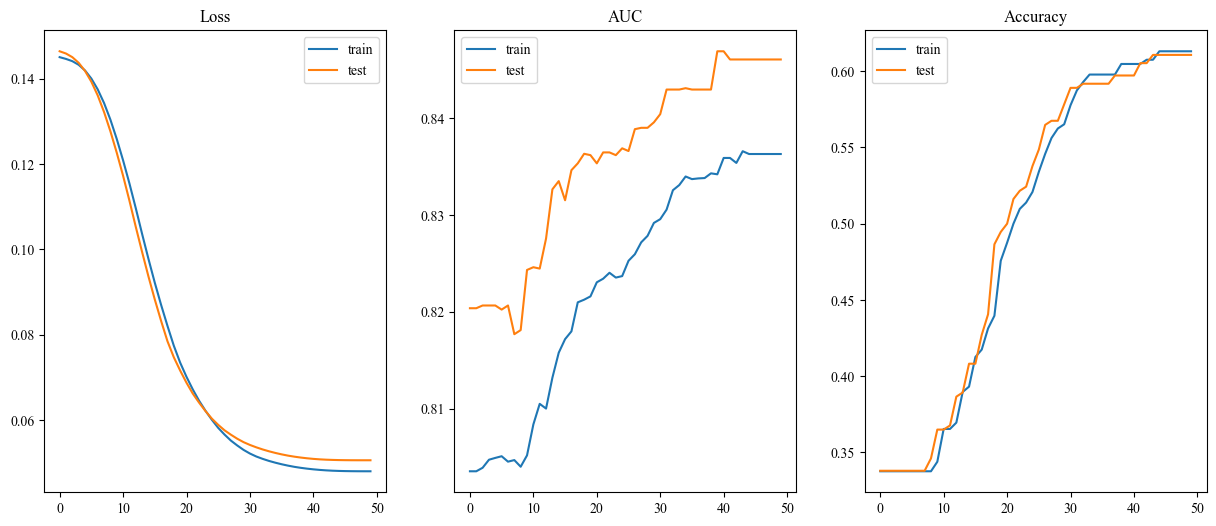

In [34]:
# Plot results
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(131)
ax.plot(stats_train.losses,label='train')
ax.plot(stats_test.losses,label='test')
ax.set_title('Loss')
ax.legend()

ax = fig.add_subplot(1,3,2)
ax.plot(stats_train.auc_scores,label='train')
ax.plot(stats_test.auc_scores,label='test')
ax.set_title('AUC')
ax.legend()

ax = fig.add_subplot(1,3,3)
ax.plot(stats_train.acc_scores,label='train')
ax.plot(stats_test.acc_scores,label='test')
ax.set_title('Accuracy')
ax.legend()

# Interpretation of the model

In [35]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [36]:
weights = model.criteria_layer.w().detach().numpy()[0]
interaction_weights = model.interaction_layer.w().detach().numpy()[0]
s = weights.sum()+interaction_weights.sum()
weights = weights/s
interaction_weights = interaction_weights/s

interactions = np.zeros((num_criteria,num_criteria))
weight_id =0
for i in range(num_criteria):
    for j in range(i+1,num_criteria):
        
        interactions[i,j] = interactions[j,i] = interaction_weights[weight_id]
        weight_id+=1

In [37]:
print('Criteria weights:')
print(weights)
print()
print('Criteria interctions:')
print(interactions)

Criteria weights:
[0.26056376 0.22395758 0.20610164 0.19292592]

Criteria interctions:
[[ 0.         -0.01868345  0.10433953  0.04860377]
 [-0.01868345  0.          0.02041416  0.00965525]
 [ 0.10433953  0.02041416  0.         -0.04787821]
 [ 0.04860377  0.00965525 -0.04787821  0.        ]]


In [38]:
shapley = weights + interactions.sum(0)/2
print('Importance of criterina (Shapley value):')
print(shapley)

Importance of criterina (Shapley value):
[0.32769369 0.22965056 0.24453938 0.19811632]
